# Сборный проект-4

Поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

## Загрузка данных




Импортируем библиотеки и модули, необходимые для выполнения проекта:

In [4]:
#!python -m spacy download en_core_web_sm

2023-04-03 19:43:55.585618: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-03 19:43:58.247420: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-03 19:43:58.306608: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-03 19:43:58.308784: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [5]:
#!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 94.6 MB/s eta 0:00:00


In [107]:
import math
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import re
import spacy
import torch
import torch.nn as nn
import torchvision.models as models
from PIL import Image
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm, tqdm_notebook 
from torchvision import transforms
from sklearn.preprocessing import  StandardScaler 



В файле train_dataset.csv собрана информация, необходимая для обучения: 
- имя файла изображения, 
- идентификатор описания
- текст описания. 

Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.


In [7]:
train_dataset = pd.read_csv('train_dataset.csv')
train_dataset

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
...,...,...,...
5817,757046028_ff5999f91b.jpg,2061144717_5b3a1864f0.jpg#2,A man in an ampitheater talking to a boy .
5818,799486353_f665d7b0f0.jpg,2196107384_361d73a170.jpg#2,a old man walks down the uncrowded road .
5819,909808296_23c427022d.jpg,2112921744_92bf706805.jpg#2,A dog stands on the side of a grassy cliff .
5820,929679367_ff8c7df2ee.jpg,3651971126_309e6a5e22.jpg#2,A blurry photo of two dogs .


Вызовем метод info(), чтобы вывести информацию о таблице:

In [8]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


В train_dataset 5822 записи, пустых строк нет.

В файле CrowdAnnotations.tsv — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:
* 
1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

Сохраним данные из файла CrowdAnnotations.tsv в переменную `crowd_annotations` с помощью метода read_csv(). Для того, чтобы первая строка не становилась названиями колонок, передадим в метод параметр header=None и названия столбцов в параметр names:

In [9]:
crowd_annotations = pd.read_csv('CrowdAnnotations.tsv',  sep='\t', header=None, names=['image', 'query_id', 'percentage_confirmed', 'quantity_confirmed', 'quantity_disproved'])
crowd_annotations

,image,query_id,percentage_confirmed,quantity_confirmed,quantity_disproved
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.000000,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.000000,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.000000,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.000000,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.000000,0,3
...,...,...,...,...,...
47825,997722733_0cb5439472.jpg,543007912_23fc735b99.jpg#2,0.000000,0,3
47826,997722733_0cb5439472.jpg,544576742_283b65fa0d.jpg#2,0.333333,1,2
47827,997722733_0cb5439472.jpg,872622575_ba1d3632cc.jpg#2,1.000000,3,0
47828,997722733_0cb5439472.jpg,888425986_e4b6c12324.jpg#2,0.000000,0,3


Вызовем метод info(), чтобы вывести информацию о таблице:

In [10]:
crowd_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   image                 47830 non-null  object 
 1   query_id              47830 non-null  object 
 2   percentage_confirmed  47830 non-null  float64
 3   quantity_confirmed    47830 non-null  int64  
 4   quantity_disproved    47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


В crowd_annotations 47830 записей, пустых строк нет.

Вызовем метод `describe()`, чтобы лучше изучить таблицу:

In [11]:
crowd_annotations.describe()

,percentage_confirmed,quantity_confirmed,quantity_disproved
count,47830.000000,47830.000000,47830.000000
mean,0.068786,0.208488,2.820155
std,0.207532,0.628898,0.656676
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,3.000000
50%,0.000000,0.000000,3.000000
75%,0.000000,0.000000,3.000000
max,1.000000,5.000000,6.000000


Из таблицы можно сделать следующие выводы по столбцам:

- `percentage_confirmed`: В среднем 6,8% опрошенных подтверждают, что описание соответствует изображению. При этом медианное значение - 0. Минимальное значение -0, максимальное - 1, а это означает, что есть изображения с описанием, которое подвердили абсолютно все. 
  
- `quantity_confirmed`: Медианное значение - 0, при этом минимальное значение - 0, максимальное 5.
  
- `quantity_disproved`: Медианное значение - 3, значит, чаще всего 3 человека опровергают то, что описание соответствует картинке. При этом минимальное значение - 0, максимальное 6.

В файле test_queries.csv находится информация, необходимая для тестирования: 
- идентификатор запроса, 
- текст запроса
- релевантное изображение

Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.


In [12]:
test_queries = pd.read_csv('test_queries.csv', sep='|', index_col=0)
test_queries

,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg
...,...,...,...
495,989851184_9ef368e520.jpg#0,A black dog has a dumbbell in his mouth .,989851184_9ef368e520.jpg
496,989851184_9ef368e520.jpg#1,A black dog has a dumbbell in his mouth lookin...,989851184_9ef368e520.jpg
497,989851184_9ef368e520.jpg#2,A black dog holding a weight in its mouth stan...,989851184_9ef368e520.jpg
498,989851184_9ef368e520.jpg#3,A black dog holds a small white dumbbell in it...,989851184_9ef368e520.jpg


Вызовем метод info(), чтобы вывести информацию о таблице:

In [13]:
test_queries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


В test_queries 500 записи, пустых строк нет.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

Сохраним данные из файла ExpertAnnotations.tsv в переменную expert_annotations с помощью метода read_csv(). Для того, чтобы первая строка не становилась названиями колонок, передадим в метод параметр header=None и названия столбцов в параметр names:

In [14]:
expert_annotations = pd.read_csv('ExpertAnnotations.tsv', sep='\t', header=None, names=['image', 'query_id', 'expert_1', 'expert_2', 'expert_3'])
expert_annotations

,image,query_id,expert_1,expert_2,expert_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2
...,...,...,...,...,...
5817,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,1,1,1
5818,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,1,1,1
5819,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,1,1,2
5820,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,1,1,1


Вызовем метод info(), чтобы вывести информацию о таблице:

In [15]:
expert_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   expert_1  5822 non-null   int64 
 3   expert_2  5822 non-null   int64 
 4   expert_3  5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


В expert_annotations 5822 записи, пустых строк нет.

Вызовем метод `describe()`, чтобы лучше изучить таблицу:

In [16]:
expert_annotations.describe()

,expert_1,expert_2,expert_3
count,5822.000000,5822.000000,5822.000000
mean,1.436620,1.624356,1.881999
std,0.787084,0.856222,0.904087
min,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000
50%,1.000000,1.000000,2.000000
75%,2.000000,2.000000,2.000000
max,4.000000,4.000000,4.000000


Аномальных значений в таблице нет, при этом видно, что третий эксперт оценивает совпадение описания и изображений баллами выше, чем его коллеги. Так медиана для эксперта 3 составляет 2 балла, в то время как для других она равна 1. 

### Выводы

Загрузили данные и сохранили их в переменные. Выяснили, что в результате краудсорсинга с среднем только  6,8% опрошенных подтверждают, что описание соответствует изображению, при этом медианное значение - 0. 

Помимо этого выявили, что третий эксперт, согласно медиане и среднему значению, оценивает совпадение описания и изображений баллами выше, чем его коллеги (2 балла против 1). В 75% случаев все три эксперта оценивают соответствие не выше 2, что означает несоответствие описания изображению. 

## Исследовательский анализ данных


Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. 

Для решения задачи мы должны эти оценки агрегировать — превратить в одну. Сделаем это с помощью голосования большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст удалим из датасета:

In [17]:
# Исключим пары изображение-текст, где каждый эксперт поставил разные оценки
unique_votes = expert_annotations.loc[:,['expert_1', 'expert_2', 'expert_3']].apply(pd.Series.nunique, axis=1)
mask = unique_votes <= 2
expert_annotations = expert_annotations[mask]

# Определим количество голосов каждого эксперта за каждую оценку
votes = expert_annotations.apply(pd.Series.value_counts, axis=1)
# Найдем оценки, за которые проголосовала большая часть экспертов
majority_vote = votes.idxmax(axis=1)
# Запишем эти оценки в новый столбец итоговой таблицы
expert_annotations['majority_vote'] = majority_vote
expert_annotations

<ipython-input-17-30fdfc1f0bd9>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expert_annotations['majority_vote'] = majority_vote


,image,query_id,expert_1,expert_2,expert_3,majority_vote
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,1
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,1
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,1
...,...,...,...,...,...,...
5817,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,1,1,1,1
5818,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,1,1,1,1
5819,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,1,1,2,1
5820,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,1,1,1,1


Объединим таблицы с экспертными и краудсорсинговыми оценками по столбцам 'image' и 'query_id' так, чтобы все строки с экспертными оценками были в итоговой таблице.
Затем создадим функцию, которая агрегирует эти оценки по следующему правилу: если в строке есть обе оценки, тогда оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4. Если же краудсорсинговой оценки нет, тогда оценка эксперта принимается с коэффициентом 1.

А так как экспертные оценки варьируются от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — а  4 — запрос и текст соответствуют полностью, то 1 должно соответствовать вероятности 0, а 4 - вероятности 1.


In [18]:
# Объединим таблицы по столбцам 'image' и 'query_id'
merged_df = pd.merge(expert_annotations, crowd_annotations, on=['image', 'query_id'], how='left').drop(['expert_1', 'expert_2', 'expert_3'], axis=1)

#функция которая подсчитывает средний результат и возвращает его
def average_score(row):
    majority_vote = row.loc['majority_vote']
    percentage_confirmed = row.loc['percentage_confirmed']
    #проверяем есть ли краудсорсинговая оценка в строке
    if math.isnan(percentage_confirmed) :
        score = (majority_vote-1)/3
    else:
        score = (majority_vote-1)/3*0.6 + percentage_confirmed*0.4
    return score

merged_df['average_score']=merged_df.apply(average_score, axis=1)
merged_df = merged_df.drop(['majority_vote', 'percentage_confirmed', 'quantity_confirmed', 'quantity_disproved'], axis=1)
merged_df

,image,query_id,average_score
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.000000
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.000000
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.000000
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.333333
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.000000
...,...,...,...
5691,997722733_0cb5439472.jpg,2981702521_2459f2c1c4.jpg#2,0.000000
5692,997722733_0cb5439472.jpg,2985679744_75a7102aab.jpg#2,0.000000
5693,997722733_0cb5439472.jpg,3150742439_b8a352e1e0.jpg#2,0.000000
5694,997722733_0cb5439472.jpg,3375070563_3c290a7991.jpg#2,0.000000


Проверим с помощью метода describe(), как сработало заполнение:

In [19]:
merged_df.describe()

,average_score
count,5696.000000
mean,0.172265
std,0.261057
min,0.000000
25%,0.000000
50%,0.000000
75%,0.333333
max,1.000000


Заполнение сработало корректно, минимальное значение - 0, максимальное - 1. Но при этом 75% значений лежит в диапазоне от 0 до 0,33, что указывает на дисбаланс.

## Проверка данных

В некоторых странах, где работает компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

Cделаем это в несколько этапов:

1) Предобработаем тексты описаний. Приведем все к нижнему регистру, очистим от ненужных символов(если таковые имеются), а также лемматизируем их.

2) Создадим список слов, которые прямо указывают на ребенка на изображении, а также список слов, которые могут указывать, но только в сочетании с определенными прилагательными.
   
3) Удалим нужные строки из таблицы при помощи написанной функции.

Сначала переведем все описания к нижнему регистру:

In [20]:
train_dataset['query_text'] = train_dataset['query_text'].str.lower()

Создадим 2 функции, которые лемматизируют комментарии (функция lemmatize(text)) и очистят их от ненужных символов(clear_text(text)), если таковые есть:

In [21]:
nlp = spacy.load("en_core_web_sm")

def lemmatize(text):
    lemm_list = nlp(text)
    lemm_text = str(lemm_list)
        
    return lemm_text


def clear_text(text):
    processed_text = re.sub(r'[^A-Za-z ]', ' ', text)
    return ' '.join(processed_text.split())

Применим написанные функции к нашему датасету. Сначала отчистим данные от ненужных символов с помощью clear_text(x). Для того, чтобы был виден прогресс выполнения кода, вызовем вместо метода apply() другой - progress_apply():

In [22]:

tqdm.pandas()
train_dataset['query_text'] = train_dataset['query_text'].progress_apply(lambda x: clear_text(x))

100%|██████████| 5822/5822 [00:00<00:00, 234354.19it/s]


Теперь проведем лемматизацию комментариев при помощи метода lemmatize():

In [23]:
train_dataset['query_text'] = train_dataset['query_text'].progress_apply(lambda x: lemmatize(x))

100%|██████████| 5822/5822 [00:43<00:00, 135.02it/s]


Теперь создадим списки слов, а также функцию, которая проверит на содержание этих слов в текстах:

In [24]:

# список слов, которые могут попадать под ограничения:
#слова однозначно обозначающие детей до 18 лет
restricted_words = ['baby' , 'babies', 'child',  'children', 'kid', 'kids', 'juvenile', 'minor', 'minors', 'youth', 'youths', 'teen', 'teens', 'teenager', 'teenagers', 'underage']
#слова, которые в сочетании с прилагаетльными обозначают детей до 18 лет
attention_words = ['girl', 'boy', 'girls', 'boys']
attention_adjectives = ['small', 'little', 'young']
# функция для проверки наличия слов из списка в тексте
def check_restricted_words(row):
    text = row.loc['query_text']
    for word in text.split():
        if word in restricted_words:
            return True
        elif word in attention_words:
            for w in text.split():
                if w in attention_adjectives:
                    return True

    return False
# добавляем столбец с признаком наличия "запрещенных" слов в тексте
train_dataset['restricted_words'] = train_dataset.apply(check_restricted_words, axis=1)
#удалим строки, содержащие описание с детьми
train_dataset = train_dataset[~train_dataset['restricted_words']].drop('restricted_words', axis=1)
train_dataset

,image,query_id,query_text
12,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,a girl wearing a yellow shirt and sunglasses s...
13,1167669558_87a8a467d6.jpg,2718495608_d8533e3ac5.jpg#2,a girl wearing a yellow shirt and sunglasses s...
14,2616643090_4f2d2d1a44.jpg,2718495608_d8533e3ac5.jpg#2,a girl wearing a yellow shirt and sunglasses s...
15,2648165716_02e2e74fd6.jpg,2718495608_d8533e3ac5.jpg#2,a girl wearing a yellow shirt and sunglasses s...
16,2718495608_d8533e3ac5.jpg,2718495608_d8533e3ac5.jpg#2,a girl wearing a yellow shirt and sunglasses s...
...,...,...,...
5817,757046028_ff5999f91b.jpg,2061144717_5b3a1864f0.jpg#2,a man in an ampitheater talking to a boy
5818,799486353_f665d7b0f0.jpg,2196107384_361d73a170.jpg#2,a old man walks down the uncrowded road
5819,909808296_23c427022d.jpg,2112921744_92bf706805.jpg#2,a dog stands on the side of a grassy cliff
5820,929679367_ff8c7df2ee.jpg,3651971126_309e6a5e22.jpg#2,a blurry photo of two dogs


Видим, что очищенный датасет теперь состоит из 4769 строк. То есть были удалены 1053 строки.

Так как потом нам надо будет обучать модель на основе описаний, изображений и агрегированных оценок, то соединим train_dataset и merged_df на основе пары значений 'image' и 'query_id':

In [25]:
train_dataset = pd.merge(train_dataset, merged_df, on=['image', 'query_id'], how='inner')
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4662 entries, 0 to 4661
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   image          4662 non-null   object 
 1   query_id       4662 non-null   object 
 2   query_text     4662 non-null   object 
 3   average_score  4662 non-null   float64
dtypes: float64(1), object(3)
memory usage: 182.1+ KB


## Векторизация изображений

Перейдём к векторизации изображений.

Сделаем это с помощью ResNet-18, исключив полносвязные слои, которые отвечают за конечное предсказание:

In [26]:
resnet = models.resnet18(pretrained=True) #загружаем претренированную модель 

/opt/python/envs/default/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/python/envs/default/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/datalore/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


In [27]:
for param in resnet.parameters():
    param.requires_grad_(False) 

In [28]:
modules = list(resnet.children())[:-2]
resnet = nn.Sequential(*modules) 

In [29]:
norm = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    norm,
]) 

In [30]:
#чтение изображений
names = train_dataset['image'].values
image_vec = []
i=1
for name in names:
    print(i)
    img = Image.open("/data/notebook_files/train/"+name).convert('RGB')
    image_tensor = preprocess(img)
    image_tensor = image_tensor.unsqueeze(0)
    output_tensor = resnet(image_tensor).flatten()
    image_vec.append(output_tensor)
    i=i+1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [82]:
outputs_tensor = torch.stack(image_vec)

## Векторизация текстов

Следующий этап — векторизация текстов. Сделаем это с помощью tf-idf:

Создадим корпус описаний. Преобразуем столбец 'query_text' в список текстов:

In [83]:
train_corpus = train_dataset['query_text'].values

С помощью nltk избавимся от стоп-слов, а с помощью TfidfVectorizer подсчитаем величину TF-IDF для текстов:

In [84]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords)

text_vec = count_tf_idf.fit_transform(train_corpus)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/datalore/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Объединение векторов

Объединим векторы изображений и векторы текстов с целевой переменной.

In [85]:
# Преобразование text_vec в Tensor
text_vec = torch.tensor(text_vec.todense())

# Объединение векторов
combined_vec = torch.cat((outputs_tensor, text_vec), axis=1)

## Обучение модели предсказания соответствия

In [86]:
target = train_dataset['average_score']

In [87]:
#разобъем тренировочный датасет на на обучающую и тестовую выборки

features_train, features_test, target_train, target_test = train_test_split(combined_vec,target, test_size=0.3, random_state=12345)

Применим StandartScaler, чтобы стандартизировать данные:

In [102]:

scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

In [103]:

lr_model = LinearRegression()
lr_model.fit(features_train, target_train)

LinearRegression()

In [104]:

# Прогнозирование на тестовой выборке
y_pred = lr_model.predict(features_test)

# Вычисление rmse
rmse = mean_squared_error(target_test, y_pred)
rmse


1.89394232909003e+23

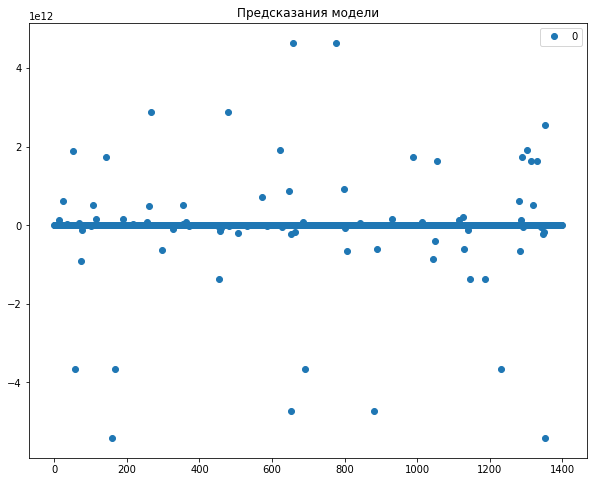

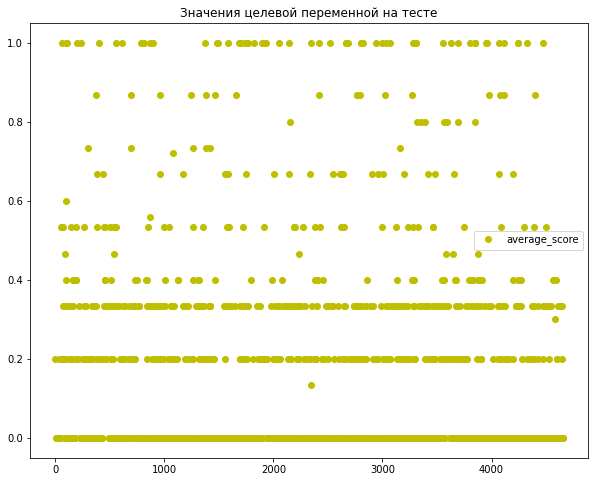

In [109]:

pd.DataFrame(y_pred).plot(style='o', figsize=(10,8), title='Предсказания модели')
pd.DataFrame(target_test).plot(style='o',color='y', figsize=(10,8), title='Значения целевой переменной на тесте')
plt.show()

## Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

## Выводы

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Проверены экспертные оценки и краудсорсинговые оценки
- [x]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [ ]  Изображения векторизованы
- [ ]  Текстовые запросы векторизованы
- [ ]  Данные корректно разбиты на тренировочную и тестовую выборки
- [ ]  Предложена метрика качества работы модели
- [ ]  Предложена модель схожести изображений и текстового запроса
- [ ]  Модель обучена
- [ ]  По итогам обучения модели сделаны выводы
- [ ]  Проведено тестирование работы модели
- [ ]  По итогам тестирования визуально сравнили качество поиска